   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000800,0.068271,0.991228,1.000000,0.981283,0.990553
2,0.002000,0.000376,1.000000,1.000000,1.000000,1.000000
3,0.000300,0.000260,1.000000,1.000000,1.000000,1.000000


Validation Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


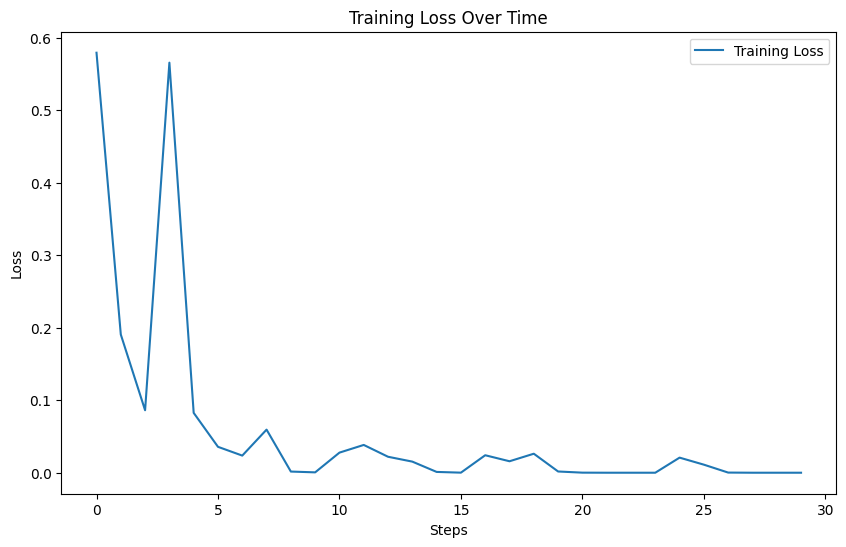

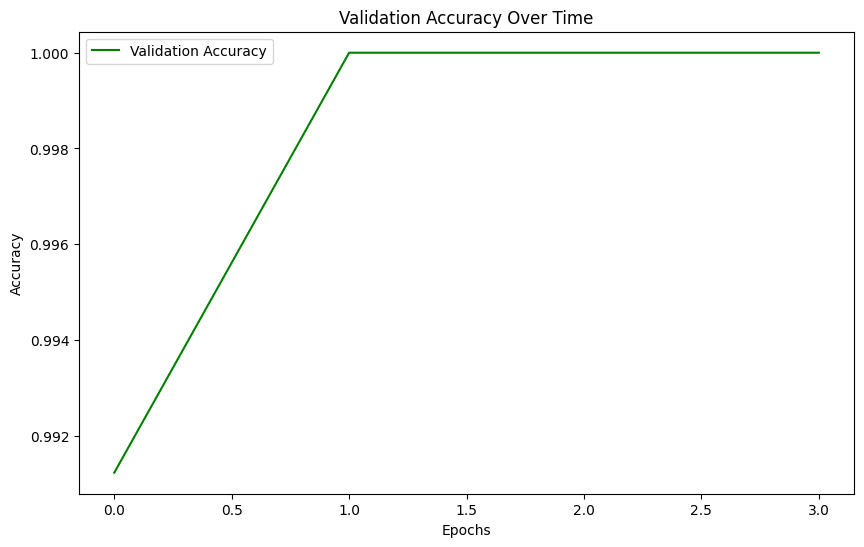

Total training time: 2 minutes and 6 seconds


In [1]:
# Install necessary libraries
!pip install transformers datasets scikit-learn matplotlib seaborn torch --quiet

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Measure total training time
start_time = time.time()

# Load the dataset
data = pd.read_csv('/content/data.csv')

# Assuming the dataset has 'text' and 'label' columns
# 'label' should be 1 for fake news and 0 for true news

# Check for missing values and handle them if necessary
data.dropna(inplace=True)

# Prepare text and labels
X = data['URLs'].tolist()
y = data['Label'].tolist()

# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the tokenizer and tokenize the input texts
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize the datasets with reduced max length for faster training
train_encodings = tokenizer(X_train, padding=True, truncation=True, max_length=64, return_tensors='pt')
val_encodings = tokenizer(X_val, padding=True, truncation=True, max_length=64, return_tensors='pt')

# Convert the labels to torch tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# Prepare the dataset as per Trainer class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

# Load the pre-trained ALBERT model for sequence classification
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

# Define the evaluation metric
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Training arguments with larger batch size and reduced number of steps
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,  # Larger batch size for faster training
    per_device_eval_batch_size=32,
    num_train_epochs=3,              # Set to 3 epochs as requested
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

# Print evaluation metrics
print(f"Validation Accuracy: {eval_result['eval_accuracy']}")
print(f"Precision: {eval_result['eval_precision']}")
print(f"Recall: {eval_result['eval_recall']}")
print(f"F1 Score: {eval_result['eval_f1']}")

# Plot training loss and evaluation accuracy
train_loss = trainer.state.log_history
train_loss_values = [entry['loss'] for entry in train_loss if 'loss' in entry]
eval_accuracy_values = [entry['eval_accuracy'] for entry in train_loss if 'eval_accuracy' in entry]

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(eval_accuracy_values, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time")
plt.legend()
plt.show()

# Save the model
model.save_pretrained('./saved_model_albert')
tokenizer.save_pretrained('./saved_model_albert')

# Measure and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time // 60:.0f} minutes and {total_time % 60:.0f} seconds")


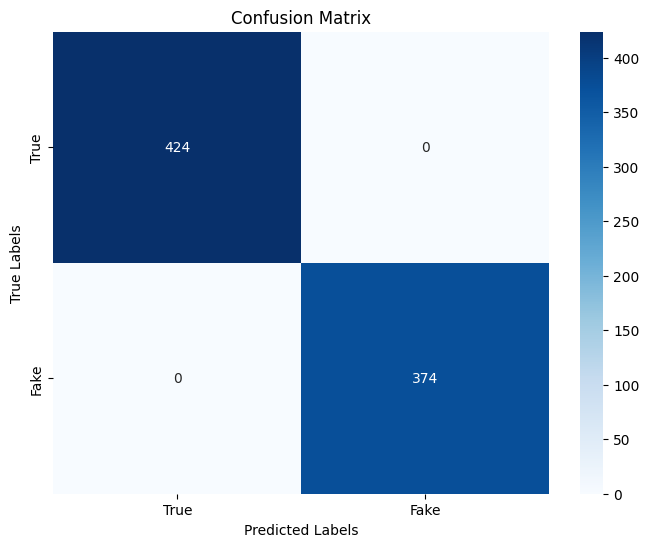

              precision    recall  f1-score   support

        True       1.00      1.00      1.00       424
        Fake       1.00      1.00      1.00       374

    accuracy                           1.00       798
   macro avg       1.00      1.00      1.00       798
weighted avg       1.00      1.00      1.00       798



In [2]:
# prompt: give me confusion matrix and other graph visualisation and give the classsification report also

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the validation dataset
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_val, predicted_labels, target_names=['True', 'Fake'])
print(report)

# You can also create other visualizations like ROC curve or precision-recall curve
# using the predictions and true labels.


In [6]:
# prompt:  give me the different code for the above model for taking user input of news article and give the correct prediction true or fake

import pandas as pd
import numpy as np
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import torch

# Load the saved model and tokenizer
model = AlbertForSequenceClassification.from_pretrained('./saved_model_albert')
tokenizer = AlbertTokenizer.from_pretrained('./saved_model_albert')

# Function to predict the news article label
def predict_news(news_article):
    inputs = tokenizer(news_article, padding=True, truncation=True, max_length=64, return_tensors='pt')
    outputs = model(**inputs)
    predicted_label = np.argmax(outputs.logits.detach().numpy())

    if predicted_label == 1:
        return "Fake News"
    else:
        return "True News"

# Get user input
user_input = input("Enter the news article: ")

# Make the prediction
prediction = predict_news(user_input)

# Print the prediction
print(f"The news article is classified as: {prediction}")


Enter the news article: By Aaron Kesel As former White House chief of staff and current Chicago Mayor Rahm Emanuel has said: “You never let a serious crisis go to waste.” While everyone was worried about the hurricanes, U.S. President Donald Trump signed away the Fourth Amendment buried in a new bill. He set a precedent by empowering the police state to allow warrantless searches in parts of VA, MD and D.C. near the Metro train system. The government can now openly enter and search private property without a warrant in parts of Virginia, Maryland and D.C. The House Joint Resolution 76 was signed into law on Tuesday, Aug. 22, by President Trump. The text is rather boring, starting off with: “Granting the consent and approval of Congress for the Commonwealth of Virginia, the State of Maryland, and the District of Columbia to enter into a compact relating to the establishment of the Washington Metrorail Safety Commission.” CNN explained, “This law lets Virginia, Maryland and the District 